<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [ ]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20

In [ ]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(embedding_dim, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x, h):
    h2 = torch.tanh(self.i2h(x) + self.h2h(h) + self.hb2)
    y = self.h2o(h2) + self.ob
    return y, h2


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn_list = nn.ModuleList([VanillaRNN(vocab_size, embedding_dim, hidden_size) for _ in range(deep_num)]
  def forward(self, x, h):
    x = self.embedding(x)
    for rnn in self.rnn_list:
      x, h = rnn(x, h)
    return x, h

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, 3)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

Okay, the above VanillaRNN's forward function is very simple.
it just go through one time step.
I think I should go further to go through N timestep in the forward function.
okay, let do it.


In [ ]:
class ManillaRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(ManillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.i2h = nn.Linear(embedding_dim, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x):
    h = torch.zeros(1, self.hidden_size)
    for i in range(x.shape[1]):
      t = self.embedding(x[:,i])
      h = torch.tanh(self.i2h(t) + self.h2h(h) + self.hb2)
      y = self.h2o(h) + self.ob
    return y

criterion = nn.CrossEntropyLoss()

model = ManillaRNN(vocab_size, embedding_dim, hidden_size)
optimizer = optim.Adagrab(model.parameters(), lr=learning_rate)

Now tusi ManillaRNN is different with the VanillaRNN.
It will iterate all the time step, drop the intermediate output, and only output the final one.

But I am not going to rewrite the training function to retrain the new model.
Because I think the VanillaRNN is more better and controlable than this one.


apart from that, we could also deep the layers in the RNN.
The idea is that there could be serveral layers between the input and the output. based on the Vanilla RNN, let us do it.

In [ ]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(embedding_dim, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x, h):
    h2 = torch.tanh(self.i2h(x) + self.h2h(h) + self.hb2)
    y = self.h2o(h2) + self.ob
    return y, h2


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn_list = nn.ModuleList([VanillaRNN(vocab_size, embedding_dim, hidden_size) for _ in range(deep_num)]
  def forward(self, x, h):
    x = self.embedding(x)
    for rnn in self.rnn_list:
      x, h = rnn(x, h)
    return x, h

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = VanillaRNN(vocab_size, embedding_dim, hidden_size)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
def generateMiniBatch(start_idx):
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [ ]:
stopi = []
lossi = []

In [ ]:
# Training loop
num_iterations = 10000
p = 0
for iteration in range(num_iterations):

  if p + seq_length + 1 > len(data):
    p = 0;

  inputs, targets = generateMiniBatch(p)

  optimizer.zero_grad()

  totalloss = 0
  hprev = torch.zeros(1, hidden_size)  # Reset RNN memory
  for i in range(seq_length):
    input_char = inputs[:,i].unsqueeze(1)
    output_char = targets[:,i]

    predict_char, hprev = model(input_char, hprev)

    loss = criterion(predict_char.squeeze(1), output_char)
    totalloss += loss.item()

    loss.backward()
    hprev = hprev.detach()

    for param in model.parameters():
      if param.grad is not None:
        param.grad.data.clamp_(-5, 5)

    optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss/seq_length}')
    stopi.append(iteration)
    lossi.append(totalloss/seq_length)

  p += seq_length  # Move data pointer

Iteration 0, Loss: 2.615601406097412
Iteration 1000, Loss: 2.326109142303467
Iteration 2000, Loss: 2.2084765434265137
Iteration 3000, Loss: 2.179548645019531
Iteration 4000, Loss: 1.7724802780151367
Iteration 5000, Loss: 2.267986617088318
Iteration 6000, Loss: 2.35547456741333
Iteration 7000, Loss: 2.152554836273193
Iteration 8000, Loss: 2.244594888687134
Iteration 9000, Loss: 2.174146752357483


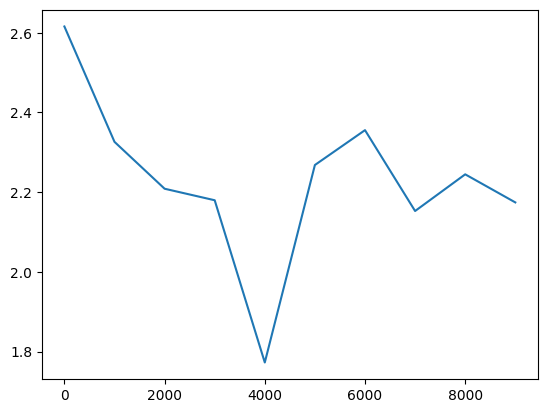

In [ ]:
plt.plot(stopi, lossi)

In [ ]:
# Sample from the model
def sample(model, seed_ix, n):
  h = torch.zeros(1, hidden_size)
  x = torch.tensor(seed_ix, dtype=torch.long).view(1, 1)
  ixes = []

  for _ in range(n):
    outputs, h = model(x, h)
    p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    x = torch.tensor(ix, dtype=torch.long).view(1, 1)
    ixes.append(ix)

  return ixes

In [ ]:
# Generate sample text
sample_ix = sample(model, char_to_ix[data[0]], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(f'Generated Text:\n{txt}')

Generated Text:
:
Fontir mind in thimin id ind ludlolacind lingo bincpot of be cy,
Bak Linde scanof githacy lrnd loutm darich cin fiorins herst; ky amce, is int,
Band,
Yoranlllllkt:
Me ileramun lf he acent, ind, ulilll cond;
Brastou butains an, sin thid Ho ange;
Menl fedrriretcay st lore wind wrt in, minst
Blis Ho fom
Lar bindinriris
ESn.

Lin bil soramt, inoflor ifis llirofcing;
Blice yiow iu ifanis
Hen,
Haninrcoutail minof walleced ied defin my
BRKINGLAM:
Basty YachiThethbingcerothay,
plmor ofild ik
GLOUCELLOULASrinoflavind intheank ind hit'ds youllan fous ESTEveten in ern, ated atanlt yore shins
Fird Lod hatrsble,
Hinll ren nirell Hoo it ofinndan Lafe this Linco thelly,
AAUCEprere de e oblull.

Whin indty ance ot woinlll civinens dinof ifind,
Balinot?

Lor,
Poreld pind nave, houl brencomerind, inr ilichitnd lil,
ER:
Sam Helind hilpp
Clorry.

LLOUCINGLOUCER:
Butend lentray canofnd
An:
Whinseand bry,
F of tind,
And;
Dae ie sad ey alfy,
And thae of bacitin dilis Ler pierd furin,
Woust 